# Imports and Functions

In [1]:
import math 
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backend_bases import MouseButton
import matplotlib.path as path
from matplotlib.colors import ListedColormap
import numpy as np
from numpy import load
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KDTree
%matplotlib notebook

global selection_model
global threshold
threshold = 20 #300 works
import random
from random import randint

global cm
global cm_bright
global wales
global maxiter
global numcoords
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

wales = load('walesoutline1.npy')
wales = path.Path(wales)


maxiter = 21
numcoords = 2
selection_model = 0 #0 for 0.5, 1 for isolated, 2 for random, 3 for best

In [2]:
import math
def normpdf(x, mean, sd):
    var = float(sd)**2
    denom = (2*math.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom

In [3]:
def xnew(x): 
    return (-5)+(((x+5)*(10+5))/(51+5))
def ynew(y): 
    return ((y+2)*(15))/(55)

def branin(x, a=1, b=5.1/(4*(np.pi**2)), c=5/np.pi, r=6, s=10, t=1/(8*np.pi), noise=0.1):
       
    return a*(x[1]-(b*(x[0]**2))+c*x[0]-r)**2+(s*(1-t)*np.cos(x[0]))+s

def braninColor(x, threshold):
    
    if branin((xnew(x[0]),xnew(x[1])))>threshold:
        return 1
    else:
        return 0   

In [4]:
def calculateModel():
    
    global X
    global Z
    global Z_model_pred
    global Znew
    global ZBranin
    global xx,yy
    global Big_df
    global Big_df_land


    x_min, x_max = -5, 51 
    y_min, y_max = -2, 53
    h = .5  # step size in the mesh

    Coords_df = pd.DataFrame(coords,columns=['XPos','YPos','Type'])
    DT_X_Values = Coords_df.drop(['Type'],axis=1)

    X = DT_X_Values.to_numpy().tolist()
    X = np.array(X)

    DT_Y_Values = Coords_df.drop(['XPos'],axis=1)
    DT_Y_Values = DT_Y_Values.drop(['YPos'],axis=1)
    y = DT_Y_Values.to_numpy().ravel()



    clf = ExtraTreesClassifier(n_estimators = 100)
    clf.fit(X, y)
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
    
    ZBranin = []
    branincoords = np.c_[xx.ravel(), yy.ravel()]
    for i in range(12320):
        ZBranin.append(braninColor(branincoords[i],20))



    Z_model_prob = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z_model_prob = Z_model_prob.reshape(xx.shape)                                                      #Z is [model_probs]
    Z_model_pred = clf.predict(np.c_[xx.ravel(), yy.ravel()])[:]                        #Z_model_pred is [model_predictions]

    Big_df = pd.DataFrame(xx.ravel(), columns=['xx'])#
    Big_df.insert(1, 'yy',yy.ravel())
    Big_df.insert(2, 'Z_model_predictions', Z_model_pred.ravel())
    Big_df.insert(3, 'Z_model_predictions_flattened', 0)
    Big_df.insert(4, 'Z_model_probs', Z_model_prob.ravel())
    Big_df.insert(5, 'Z_model_probs_flattened_SEA', 0)
    Big_df.insert(6, 'Z_model_probs_flattened_0', 0)
    Big_df.insert(7, 'Surrogate_model_predictions', ZBranin)
    Big_df.insert(8, 'Surrogate_model_predictions_flattened', 0)

    for i in range(12320):

        if (wales.contains_points([(Big_df.iat[i,0],Big_df.iat[i,1])])[0]):
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_probs']
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = Big_df.iloc[i]['Surrogate_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = Big_df.iloc[i]['Z_model_probs']

        else:
            Big_df.loc[i, 'Z_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = 'SEA'
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = 0

    Z_model_predictions = Big_df["Z_model_predictions"].to_numpy()
    Z_model_predictions_flattened = Big_df["Z_model_predictions_flattened"].to_numpy()
    Z_model_probs = Big_df["Z_model_probs"].to_numpy()
#     Z_model_probs_flattened = Big_df["Z_model_probs_flattened"].to_numpy()
    Surrogate_model_predictions = Big_df["Surrogate_model_predictions"].to_numpy()
    Surrogate_model_predictions_flattened = Big_df["Surrogate_model_predictions_flattened"].to_numpy()

    Big_df_land = Big_df[Big_df['Z_model_predictions_flattened'] != 'SEA']

    Contour_model = Big_df["Z_model_probs_flattened_0"].to_numpy()
    Contour_model = Contour_model.reshape(xx.shape) 


    plt.cla()
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic_r')
    # plt.axis("off")
    plt.grid()
    ax.contourf(xx, yy, Contour_model, 40, cmap=cm, alpha=
                0.4)

    plt.plot()

    plt.show()


In [5]:
def find_isolated_point():
       
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]

    testpoints = tmp_df[['xx','yy']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        if dist>maxdist:
            maxdist = dist
            maxind = ind
            ifinal = i

#     ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)
#     plt.plot()
#     plt.show()
#     fig1.show()
    print('isolated', testpoints[ifinal])
#     return testpoints[ifinal]
    
def find0_5():
    
    tmp_df = Big_df.iloc[(Big_df['Z_model_probs_flattened_0']-0.50).abs().argsort()[:2]]
    value = randint(0, len(tmp_df.index)-1)
    uncertain_coord = [tmp_df.iloc[value]['xx'],tmp_df.iloc[value]['yy']]
        
    ax.scatter(uncertain_coord[0], uncertain_coord[1], c='#00FF00', s=25)
    plt.plot()
    plt.show()    
    fig1.show()
      
#     print('0_5', uncertain_coord)
    return uncertain_coord

def random_point():
    
    tmp_df = Big_df_land.iloc[::5, :]
    testpoints = tmp_df[['xx','yy']].to_numpy()
                    
    ifinal = randint(0,len(testpoints.tolist()))
    
    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()
    
    fig1.show()
    
    return testpoints[ifinal]

def best():
    
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]
    score = 0

    testpoints = tmp_df[['xx','yy']].to_numpy()
    testpoints1 = tmp_df[['Z_model_probs']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        prob = testpoints1[i]
        tmp_score = dist*normpdf(prob,0.5,0.05)
        if tmp_score>score:
            ifinal = i
            distfinal = dist
            probfinal = prob
            score = tmp_score

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()

    fig1.show()
    
    find0_5()
    find_isolated_point()
    
    print(distfinal)
    print(probfinal)
    print(score)
    print('best',testpoints[ifinal])

    return testpoints[ifinal]
    
    



In [6]:
def Accuracy():
    
    correctPredictions = 0
    incorrectPredictions = 0

    for i in range(len(Big_df_land.index)):
        if ((Big_df_land.iloc[i]["Z_model_predictions"])==(Big_df_land.iloc[i]["Surrogate_model_predictions"])):
            correctPredictions+=1
        else:
            incorrectPredictions+=1


    accuracy = (correctPredictions)/((
    incorrectPredictions+correctPredictions))
    accuracyArray.append(accuracy)

    print('Accuracy is',accuracy)
    

def printGraph():
    
    xAxis = []
    for i in range(len(accuracyArray)):
        xAxis.append(i+1)

    plt.scatter(xAxis, accuracyArray) 
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy over time')
    plt.ylim(0.3, 1.0)  
    plt.show()

# Plot first graph

experiment:  0


<IPython.core.display.Javascript object>


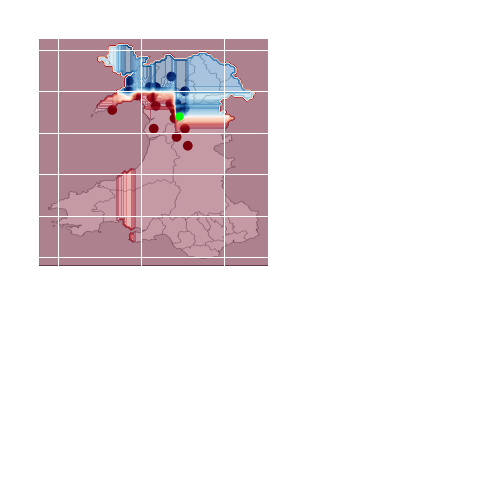

iteration  1
Accuracy is 0.4781772736012305
iteration  2
Accuracy is 0.5516246875600846
iteration  3
Accuracy is 0.5798884829840415
iteration  4
Accuracy is 0.5716208421457412
iteration  5
Accuracy is 0.564891367044799
iteration  6
Accuracy is 0.610267256296866
iteration  7
Accuracy is 0.6006537204383773
iteration  8
Accuracy is 0.5956546817919631
iteration  9
Accuracy is 0.6177658142664872
iteration  10
Accuracy is 0.60680638338781
iteration  11
Accuracy is 0.5985387425495097
iteration  12
Accuracy is 0.606037300519131
iteration  13
Accuracy is 0.617958084983657
iteration  14
Accuracy is 0.6112286098827149
iteration  15
Accuracy is 0.6083445491251682
iteration  16
Accuracy is 0.6048836762161123
iteration  17
Accuracy is 0.6187271678523361
iteration  18
Accuracy is 0.62391847721592
iteration  19
Accuracy is 0.6185348971351663
iteration  20
Accuracy is 0.6237262064987502
iteration  21
Accuracy is 0.629878869448183
experiment:  1


<IPython.core.display.Javascript object>


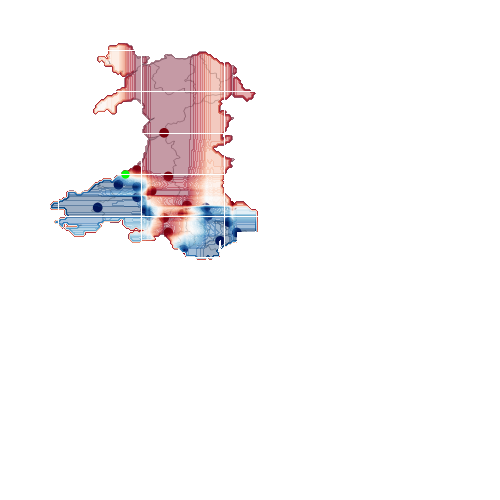

iteration  1
Accuracy is 0.48529129013651223
iteration  2
Accuracy is 0.5168236877523553
iteration  3
Accuracy is 0.5031724668333013
iteration  4
Accuracy is 0.5533551240146126
iteration  5
Accuracy is 0.5748894443376273
iteration  6
Accuracy is 0.4847144779850029
iteration  7
Accuracy is 0.5593155162468756
iteration  8
Accuracy is 0.5877715823880023
iteration  9
Accuracy is 0.5831570851759277
iteration  10
Accuracy is 0.5873870409536628
iteration  11
Accuracy is 0.5945010574889444
iteration  12
Accuracy is 0.6004614497212074
iteration  13
Accuracy is 0.6041145933474332
iteration  14
Accuracy is 0.6104595270140357
iteration  15
Accuracy is 0.6150740242261103
iteration  16
Accuracy is 0.6144972120746011
iteration  17
Accuracy is 0.6131513170544126
iteration  18
Accuracy is 0.6148817535089406
iteration  19
Accuracy is 0.6148817535089406
iteration  20
Accuracy is 0.6114208805998846
iteration  21
Accuracy is 0.6089213612766775
experiment:  2


<IPython.core.display.Javascript object>


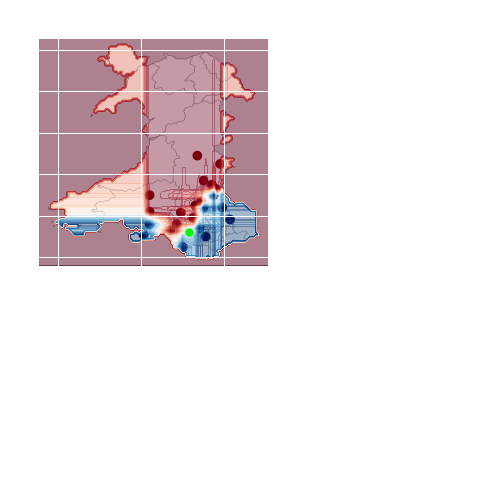

iteration  1
Accuracy is 0.4585656604499135
iteration  2
Accuracy is 0.5550855604691406
iteration  3
Accuracy is 0.5241299750048067
iteration  4
Accuracy is 0.3960776773697366
iteration  5
Accuracy is 0.4093443568544511
iteration  6
Accuracy is 0.42203422418765624
iteration  7
Accuracy is 0.4583733897327437
iteration  8
Accuracy is 0.44337627379350125
iteration  9
Accuracy is 0.45721976542972503
iteration  10
Accuracy is 0.44818304172274565
iteration  11
Accuracy is 0.4483753124399154
iteration  12
Accuracy is 0.45298980965199
iteration  13
Accuracy is 0.45183618534897135
iteration  14
Accuracy is 0.585464333781965
iteration  15
Accuracy is 0.5066333397423572
iteration  16
Accuracy is 0.5170159584695251
iteration  17
Accuracy is 0.5266294943280139
iteration  18
Accuracy is 0.5360507594693328
iteration  19
Accuracy is 0.5464333781965006
iteration  20
Accuracy is 0.5433570467217843
iteration  21
Accuracy is 0.5108632955200922
experiment:  3


<IPython.core.display.Javascript object>


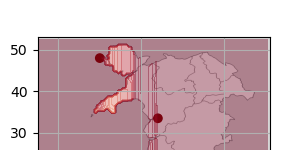

iteration  1
Accuracy is 0.5191309363583926
iteration  2
Accuracy is 0.5527783118631032
iteration  3
Accuracy is 0.5758507979234763
iteration  4
Accuracy is 0.650451836185349
iteration  5
Accuracy is 0.5431647760046145
iteration  6
Accuracy is 0.5427802345702749
iteration  7
Accuracy is 0.5395116323783887
iteration  8
Accuracy is 0.5302826379542396
iteration  9
Accuracy is 0.5472024610651798
iteration  10
Accuracy is 0.5345125937319746
iteration  11
Accuracy is 0.5473947317823495
iteration  12
Accuracy is 0.5483560853681985
iteration  13
Accuracy is 0.5431647760046145
iteration  14
Accuracy is 0.552970582580273
iteration  15
Accuracy is 0.5556623726206499
iteration  16
Accuracy is 0.5523937704287637
iteration  17
Accuracy is 0.552970582580273
iteration  18
Accuracy is 0.5502787925398962
iteration  19
Accuracy is 0.552970582580273
iteration  20
Accuracy is 0.5514324168429148
iteration  21
Accuracy is 0.5518169582772544
experiment:  4


<IPython.core.display.Javascript object>


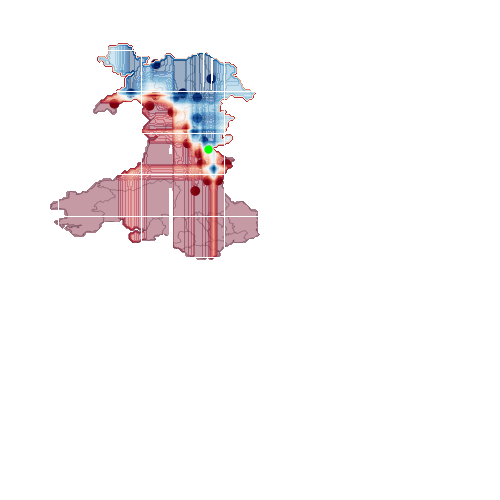

iteration  1
Accuracy is 0.5260526821765045
iteration  2
Accuracy is 0.6614112670640262
iteration  3
Accuracy is 0.6714093443568544
iteration  4
Accuracy is 0.5806575658527207
iteration  5
Accuracy is 0.661603537781196
iteration  6
Accuracy is 0.5806575658527207
iteration  7
Accuracy is 0.6748702172659105
iteration  8
Accuracy is 0.6521822726398769
iteration  9
Accuracy is 0.6679484714477985
iteration  10
Accuracy is 0.6739088636800615
iteration  11
Accuracy is 0.6729475100942126
iteration  12
Accuracy is 0.6694866371851567
iteration  13
Accuracy is 0.6727552393770428
iteration  14
Accuracy is 0.6802537973466641
iteration  15
Accuracy is 0.6754470294174197
iteration  16
Accuracy is 0.6771774658719477
iteration  17
Accuracy is 0.6696789079023264
iteration  18
Accuracy is 0.6773697365891175
iteration  19
Accuracy is 0.6677562007306287
iteration  20
Accuracy is 0.6648721399730821
iteration  21
Accuracy is 0.6802537973466641
experiment:  5


<IPython.core.display.Javascript object>


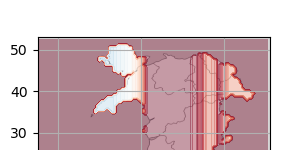

iteration  1
Accuracy is 0.46510286483368585
iteration  2
Accuracy is 0.4253028263795424
iteration  3
Accuracy is 0.4739473178234955
iteration  4
Accuracy is 0.368390694097289
iteration  5
Accuracy is 0.4689482791770813
iteration  6
Accuracy is 0.493174389540473
iteration  7
Accuracy is 0.4620265333589694
iteration  8
Accuracy is 0.43126321861180544
iteration  9
Accuracy is 0.44568352239953857
iteration  10
Accuracy is 0.44587579311670833
iteration  11
Accuracy is 0.4522207267833109
iteration  12
Accuracy is 0.43414727936935205
iteration  13
Accuracy is 0.44741395885406654
iteration  14
Accuracy is 0.4520284560661411
iteration  15
Accuracy is 0.45029801961161314
iteration  16
Accuracy is 0.5310517208229186
iteration  17
Accuracy is 0.6019996154585656
iteration  18
Accuracy is 0.6127667756200731
iteration  19
Accuracy is 0.6223803114785618
iteration  20
Accuracy is 0.6450682561045953
iteration  21
Accuracy is 0.6362238031147857
experiment:  6


<IPython.core.display.Javascript object>


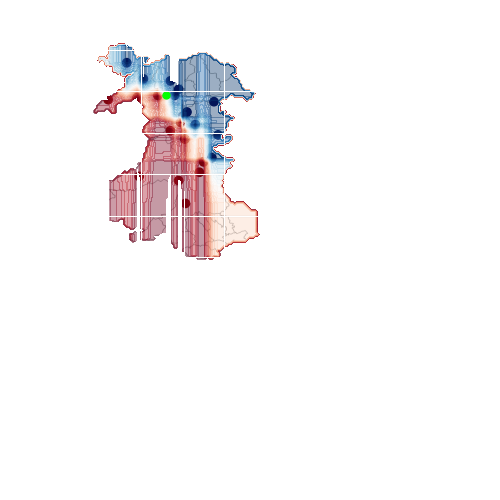

iteration  1
Accuracy is 0.5143241684291482
iteration  2
Accuracy is 0.6291097865795039
iteration  3
Accuracy is 0.6710248029225149
iteration  4
Accuracy is 0.5898865602768698
iteration  5
Accuracy is 0.6110363391655451
iteration  6
Accuracy is 0.5716208421457412
iteration  7
Accuracy is 0.5866179580849836
iteration  8
Accuracy is 0.5937319746202653
iteration  9
Accuracy is 0.5998846375696981
iteration  10
Accuracy is 0.6431455489328975
iteration  11
Accuracy is 0.6771774658719477
iteration  12
Accuracy is 0.6592962891751586
iteration  13
Accuracy is 0.676985195154778
iteration  14
Accuracy is 0.6754470294174197
iteration  15
Accuracy is 0.6698711786194963
iteration  16
Accuracy is 0.6710248029225149
iteration  17
Accuracy is 0.6677562007306287
iteration  18
Accuracy is 0.6723706979427033
iteration  19
Accuracy is 0.6656412228417612
iteration  20
Accuracy is 0.6741011343972313
iteration  21
Accuracy is 0.6725629686598731
experiment:  7


<IPython.core.display.Javascript object>


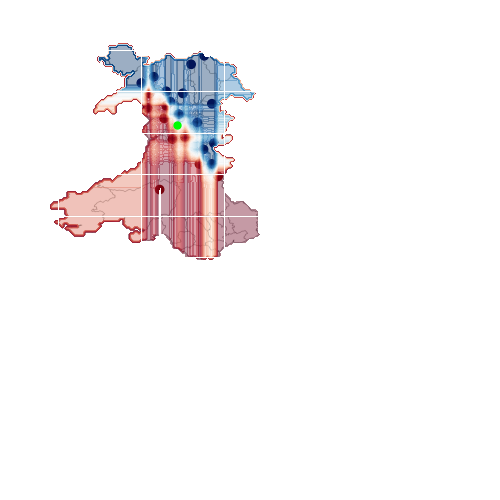

iteration  1
Accuracy is 0.6114208805998846
iteration  2
Accuracy is 0.5070178811766968
iteration  3
Accuracy is 0.6519900019227072
iteration  4
Accuracy is 0.6089213612766775
iteration  5
Accuracy is 0.5877715823880023
iteration  6
Accuracy is 0.5814266487213997
iteration  7
Accuracy is 0.6352624495289367
iteration  8
Accuracy is 0.6460296096904441
iteration  9
Accuracy is 0.6389155931551624
iteration  10
Accuracy is 0.6594885598923284
iteration  11
Accuracy is 0.6627571620842145
iteration  12
Accuracy is 0.6537204383772351
iteration  13
Accuracy is 0.656412228417612
iteration  14
Accuracy is 0.6492982118823303
iteration  15
Accuracy is 0.6608344549125168
iteration  16
Accuracy is 0.6748702172659105
iteration  17
Accuracy is 0.67525475870025
iteration  18
Accuracy is 0.6767929244376082
iteration  19
Accuracy is 0.6727552393770428
iteration  20
Accuracy is 0.6837146702557201
iteration  21
Accuracy is 0.6858296481445876
experiment:  8


<IPython.core.display.Javascript object>


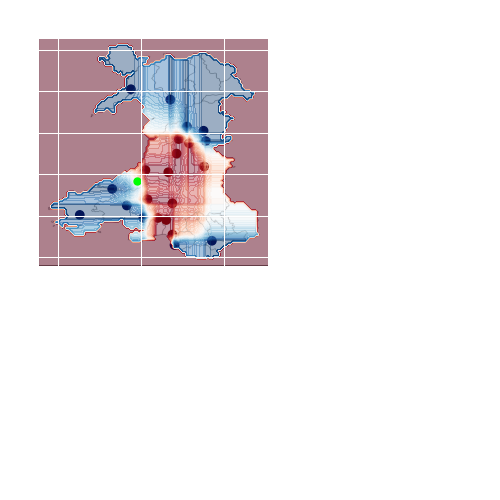

iteration  1
Accuracy is 0.5124014612574505
iteration  2
Accuracy is 0.48356085368198426
iteration  3
Accuracy is 0.560661411267064
iteration  4
Accuracy is 0.5573928090751779
iteration  5
Accuracy is 0.535858488752163
iteration  6
Accuracy is 0.5677754278023457
iteration  7
Accuracy is 0.635839261680446
iteration  8
Accuracy is 0.662372620649875
iteration  9
Accuracy is 0.7175543164776005
iteration  10
Accuracy is 0.7700442222649491
iteration  11
Accuracy is 0.7550471063257066
iteration  12
Accuracy is 0.7560084599115555
iteration  13
Accuracy is 0.7638915593155162
iteration  14
Accuracy is 0.7823495481638146
iteration  15
Accuracy is 0.7921553547394732
iteration  16
Accuracy is 0.7940780619111709
iteration  17
Accuracy is 0.816189194385695
iteration  18
Accuracy is 0.8317631224764468
iteration  19
Accuracy is 0.8394539511632378
iteration  20
Accuracy is 0.833301288213805
iteration  21
Accuracy is 0.8431070947894636
experiment:  9


<IPython.core.display.Javascript object>


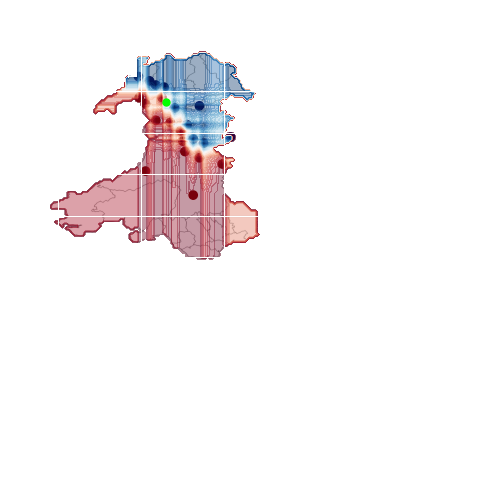

iteration  1
Accuracy is 0.5895020188425303
iteration  2
Accuracy is 0.6112286098827149
iteration  3
Accuracy is 0.6419919246298789
iteration  4
Accuracy is 0.617958084983657
iteration  5
Accuracy is 0.6031532397615843
iteration  6
Accuracy is 0.6425687367813882
iteration  7
Accuracy is 0.6617958084983657
iteration  8
Accuracy is 0.6577581234378004
iteration  9
Accuracy is 0.6666025764276101
iteration  10
Accuracy is 0.6566044991347818
iteration  11
Accuracy is 0.6691020957508171
iteration  12
Accuracy is 0.6621803499327052
iteration  13
Accuracy is 0.6748702172659105
iteration  14
Accuracy is 0.6704479907710056
iteration  15
Accuracy is 0.6637185156700635
iteration  16
Accuracy is 0.6608344549125168
iteration  17
Accuracy is 0.6733320515285522
iteration  18
Accuracy is 0.6712170736396846
iteration  19
Accuracy is 0.6706402614881753
iteration  20
Accuracy is 0.6708325322053451
iteration  21
Accuracy is 0.6719861565083638
experiment:  10


<IPython.core.display.Javascript object>


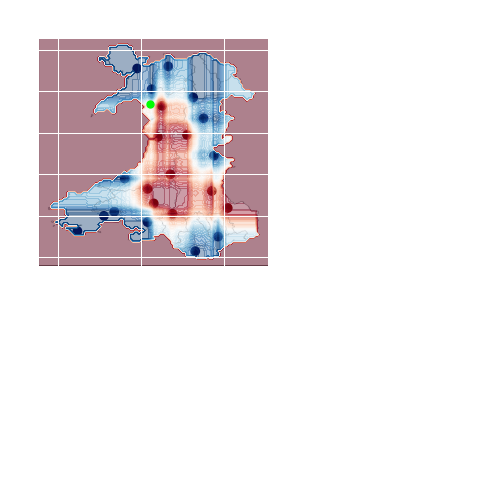

iteration  1
Accuracy is 0.5033647375504711
iteration  2
Accuracy is 0.5808498365698904
iteration  3
Accuracy is 0.5120169198231109
iteration  4
Accuracy is 0.5520092289944242
iteration  5
Accuracy is 0.6419919246298789
iteration  6
Accuracy is 0.7371659296289175
iteration  7
Accuracy is 0.7164006921745818
iteration  8
Accuracy is 0.8244568352239954
iteration  9
Accuracy is 0.8129205921938089
iteration  10
Accuracy is 0.8617573543549317
iteration  11
Accuracy is 0.7996539127090944
iteration  12
Accuracy is 0.8319553931936167
iteration  13
Accuracy is 0.857335127860027
iteration  14
Accuracy is 0.8679100173043646
iteration  15
Accuracy is 0.8798308017688906
iteration  16
Accuracy is 0.8777158238800231
iteration  17
Accuracy is 0.8890597961930398
iteration  18
Accuracy is 0.8617573543549317
iteration  19
Accuracy is 0.8804076139203999
iteration  20
Accuracy is 0.8867525475870025
iteration  21
Accuracy is 0.8811766967890791
experiment:  11


<IPython.core.display.Javascript object>


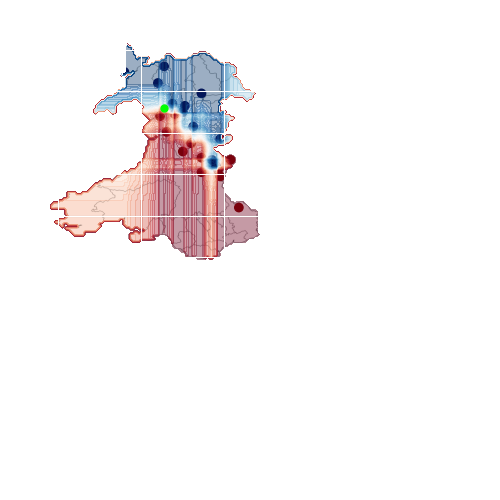

iteration  1
Accuracy is 0.5689290521053644
iteration  2
Accuracy is 0.6819842338011921
iteration  3
Accuracy is 0.6785233608921362
iteration  4
Accuracy is 0.554701019034801
iteration  5
Accuracy is 0.6248798308017689
iteration  6
Accuracy is 0.6354547202461065
iteration  7
Accuracy is 0.6489136704479908
iteration  8
Accuracy is 0.6467986925591233
iteration  9
Accuracy is 0.6527590847913862
iteration  10
Accuracy is 0.6464141511247837
iteration  11
Accuracy is 0.6506441069025187
iteration  12
Accuracy is 0.6485291290136512
iteration  13
Accuracy is 0.6523745433570467
iteration  14
Accuracy is 0.6510286483368583
iteration  15
Accuracy is 0.6666025764276101
iteration  16
Accuracy is 0.6571813112862911
iteration  17
Accuracy is 0.6573735820034609
iteration  18
Accuracy is 0.6648721399730821
iteration  19
Accuracy is 0.6650644106902519
iteration  20
Accuracy is 0.6629494328013843
iteration  21
Accuracy is 0.6631417035185542
experiment:  12


<IPython.core.display.Javascript object>


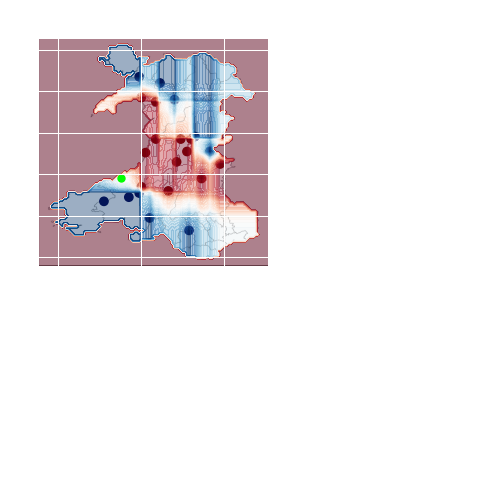

iteration  1
Accuracy is 0.5708517592770621
iteration  2
Accuracy is 0.5781580465295135
iteration  3
Accuracy is 0.5816189194385695
iteration  4
Accuracy is 0.523937704287637
iteration  5
Accuracy is 0.5923860796000769
iteration  6
Accuracy is 0.6410305710440299
iteration  7
Accuracy is 0.6773697365891175
iteration  8
Accuracy is 0.6741011343972313
iteration  9
Accuracy is 0.7165929628917516
iteration  10
Accuracy is 0.7002499519323208
iteration  11
Accuracy is 0.7033262834070371
iteration  12
Accuracy is 0.7406268025379734
iteration  13
Accuracy is 0.7838877139011728
iteration  14
Accuracy is 0.7817727360123053
iteration  15
Accuracy is 0.785425879638531
iteration  16
Accuracy is 0.787156316093059
iteration  17
Accuracy is 0.7994616419919246
iteration  18
Accuracy is 0.804268409921169
iteration  19
Accuracy is 0.8202268794462604
iteration  20
Accuracy is 0.859834647183234
iteration  21
Accuracy is 0.8644491443953086
experiment:  13


<IPython.core.display.Javascript object>


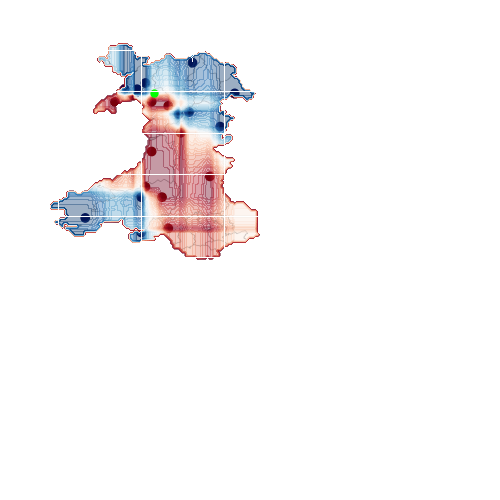

iteration  1
Accuracy is 0.5573928090751779
iteration  2
Accuracy is 0.46952509132859066
iteration  3
Accuracy is 0.6692943664679869
iteration  4
Accuracy is 0.47510094212651416
iteration  5
Accuracy is 0.4850990194193424
iteration  6
Accuracy is 0.5593155162468756
iteration  7
Accuracy is 0.5293212843683907
iteration  8
Accuracy is 0.5835416266102672
iteration  9
Accuracy is 0.6577581234378004
iteration  10
Accuracy is 0.76062295712363
iteration  11
Accuracy is 0.805998846375697
iteration  12
Accuracy is 0.8281099788502211
iteration  13
Accuracy is 0.7329359738511825
iteration  14
Accuracy is 0.7925398961738127
iteration  15
Accuracy is 0.7788886752547587
iteration  16
Accuracy is 0.7975389348202269
iteration  17
Accuracy is 0.8267640838300326
iteration  18
Accuracy is 0.8069601999615459
iteration  19
Accuracy is 0.8036915977696597
iteration  20
Accuracy is 0.8142664872139973
iteration  21
Accuracy is 0.8023457027494713
experiment:  14


<IPython.core.display.Javascript object>


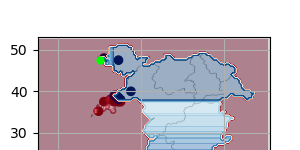

iteration  1
Accuracy is 0.33339742357238994
iteration  2
Accuracy is 0.593155162468756
iteration  3
Accuracy is 0.6231493943472409
iteration  4
Accuracy is 0.6108440684483754
iteration  5
Accuracy is 0.6169967313978081
iteration  6
Accuracy is 0.625648913670448
iteration  7
Accuracy is 0.6262257258219573
iteration  8
Accuracy is 0.6246875600845991
iteration  9
Accuracy is 0.625648913670448
iteration  10
Accuracy is 0.6252643722361084
iteration  11
Accuracy is 0.6252643722361084
iteration  12
Accuracy is 0.6254566429532782
iteration  13
Accuracy is 0.6258411843876177
iteration  14
Accuracy is 0.6258411843876177
iteration  15
Accuracy is 0.6260334551047876
iteration  16
Accuracy is 0.6258411843876177
iteration  17
Accuracy is 0.6260334551047876
iteration  18
Accuracy is 0.6260334551047876
iteration  19
Accuracy is 0.6262257258219573
iteration  20
Accuracy is 0.6262257258219573
iteration  21
Accuracy is 0.6262257258219573
experiment:  15


<IPython.core.display.Javascript object>


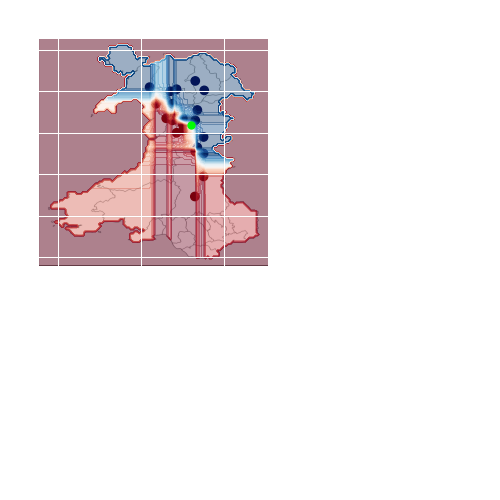

iteration  1
Accuracy is 0.5364353009036724
iteration  2
Accuracy is 0.6314170351855413
iteration  3
Accuracy is 0.6387233224379927
iteration  4
Accuracy is 0.6439146318015766
iteration  5
Accuracy is 0.6318015766198808
iteration  6
Accuracy is 0.5498942511055567
iteration  7
Accuracy is 0.6600653720438378
iteration  8
Accuracy is 0.6744856758315708
iteration  9
Accuracy is 0.6810228802153432
iteration  10
Accuracy is 0.6798692559123245
iteration  11
Accuracy is 0.6479523168621419
iteration  12
Accuracy is 0.6489136704479908
iteration  13
Accuracy is 0.6852528359930783
iteration  14
Accuracy is 0.6723706979427033
iteration  15
Accuracy is 0.6862141895789271
iteration  16
Accuracy is 0.6733320515285522
iteration  17
Accuracy is 0.6727552393770428
iteration  18
Accuracy is 0.6719861565083638
iteration  19
Accuracy is 0.6731397808113824
iteration  20
Accuracy is 0.6775620073062872
iteration  21
Accuracy is 0.6823687752355316
experiment:  16


<IPython.core.display.Javascript object>


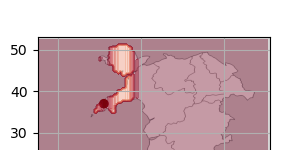

iteration  1
Accuracy is 0.5335512401461258
iteration  2
Accuracy is 0.5120169198231109
iteration  3
Accuracy is 0.5227840799846183
iteration  4
Accuracy is 0.49336666025764275
iteration  5
Accuracy is 0.5206691020957508
iteration  6
Accuracy is 0.49490482599500096
iteration  7
Accuracy is 0.5254758700249952
iteration  8
Accuracy is 0.5352816766006537
iteration  9
Accuracy is 0.5514324168429148
iteration  10
Accuracy is 0.5541242068832917
iteration  11
Accuracy is 0.5506633339742357
iteration  12
Accuracy is 0.5439338588732936
iteration  13
Accuracy is 0.5548932897519707
iteration  14
Accuracy is 0.5531628532974427
iteration  15
Accuracy is 0.5514324168429148
iteration  16
Accuracy is 0.5539319361661219
iteration  17
Accuracy is 0.5498942511055567
iteration  18
Accuracy is 0.5491251682368775
iteration  19
Accuracy is 0.5497019803883868
iteration  20
Accuracy is 0.5508556046914055
iteration  21
Accuracy is 0.5468179196308403
experiment:  17


<IPython.core.display.Javascript object>


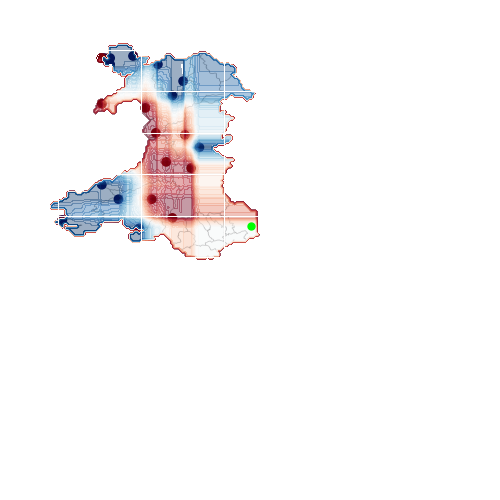

iteration  1
Accuracy is 0.4939434724091521
iteration  2
Accuracy is 0.5945010574889444
iteration  3
Accuracy is 0.5996923668525284
iteration  4
Accuracy is 0.6150740242261103
iteration  5
Accuracy is 0.6154585656604499
iteration  6
Accuracy is 0.6156508363776196
iteration  7
Accuracy is 0.6156508363776196
iteration  8
Accuracy is 0.6156508363776196
iteration  9
Accuracy is 0.6131513170544126
iteration  10
Accuracy is 0.6441069025187464
iteration  11
Accuracy is 0.6635262449528937
iteration  12
Accuracy is 0.7269755816189194
iteration  13
Accuracy is 0.7392809075177851
iteration  14
Accuracy is 0.7848490674870218
iteration  15
Accuracy is 0.8034993270524899
iteration  16
Accuracy is 0.7681215150932513
iteration  17
Accuracy is 0.850413382041915
iteration  18
Accuracy is 0.896558354162661
iteration  19
Accuracy is 0.8842530282637954
iteration  20
Accuracy is 0.8729090559507787
iteration  21
Accuracy is 0.8784849067487022
experiment:  18


<IPython.core.display.Javascript object>


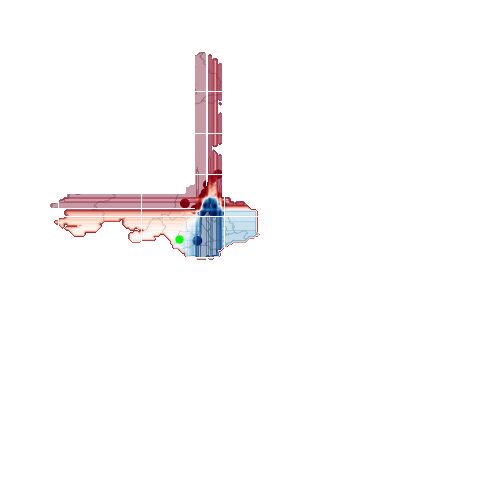

iteration  1
Accuracy is 0.4693328206114209
iteration  2
Accuracy is 0.428186887137089
iteration  3
Accuracy is 0.4472216881368968
iteration  4
Accuracy is 0.42876369928859837
iteration  5
Accuracy is 0.41318977119784656
iteration  6
Accuracy is 0.4160738319553932
iteration  7
Accuracy is 0.4178042684099212
iteration  8
Accuracy is 0.42568736781388195
iteration  9
Accuracy is 0.42953278215727747
iteration  10
Accuracy is 0.4247260142280331
iteration  11
Accuracy is 0.4291482407229379
iteration  12
Accuracy is 0.4243414727936935
iteration  13
Accuracy is 0.43337819650067294
iteration  14
Accuracy is 0.43703134012689865
iteration  15
Accuracy is 0.4408767544702942
iteration  16
Accuracy is 0.43453182080369157
iteration  17
Accuracy is 0.43799269371274757
iteration  18
Accuracy is 0.4391463180157662
iteration  19
Accuracy is 0.44414535666218036
iteration  20
Accuracy is 0.44049221303595465
iteration  21
Accuracy is 0.4652951355508556
experiment:  19


<IPython.core.display.Javascript object>


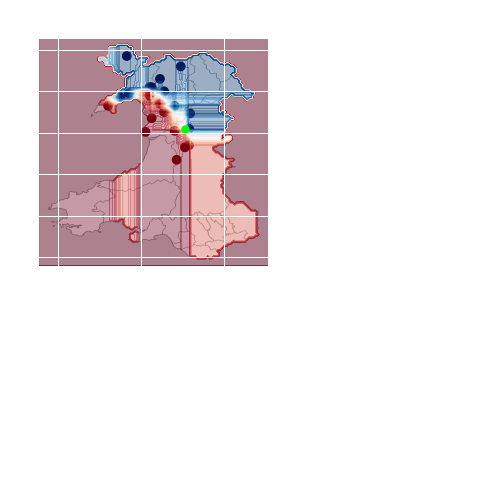

iteration  1
Accuracy is 0.6137281292059219
iteration  2
Accuracy is 0.5587387040953663
iteration  3
Accuracy is 0.549509709671217
iteration  4
Accuracy is 0.5175927706210344
iteration  5
Accuracy is 0.5531628532974427
iteration  6
Accuracy is 0.5843107094789464
iteration  7
Accuracy is 0.5952701403576235
iteration  8
Accuracy is 0.5966160353778119
iteration  9
Accuracy is 0.6046914054989425
iteration  10
Accuracy is 0.5964237646606422
iteration  11
Accuracy is 0.6206498750240338
iteration  12
Accuracy is 0.619688521438185
iteration  13
Accuracy is 0.622188040761392
iteration  14
Accuracy is 0.622188040761392
iteration  15
Accuracy is 0.6389155931551624
iteration  16
Accuracy is 0.6673716592962892
iteration  17
Accuracy is 0.6721784272255336
iteration  18
Accuracy is 0.6731397808113824
iteration  19
Accuracy is 0.6662180349932705
iteration  20
Accuracy is 0.6685252835993079
iteration  21
Accuracy is 0.671793885791194
experiment:  20


<IPython.core.display.Javascript object>


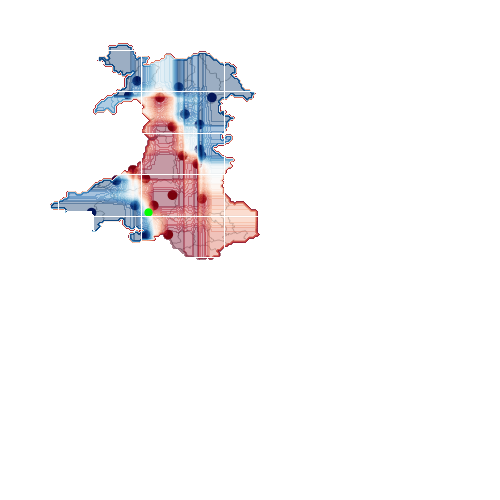

iteration  1
Accuracy is 0.5297058258027303
iteration  2
Accuracy is 0.6029609690444145
iteration  3
Accuracy is 0.6058450298019612
iteration  4
Accuracy is 0.6181503557008268
iteration  5
Accuracy is 0.6973658911747741
iteration  6
Accuracy is 0.7381272832147664
iteration  7
Accuracy is 0.7600461449721208
iteration  8
Accuracy is 0.7808113824264564
iteration  9
Accuracy is 0.7483176312247645
iteration  10
Accuracy is 0.796577581234378
iteration  11
Accuracy is 0.7692751393962699
iteration  12
Accuracy is 0.7585079792347625
iteration  13
Accuracy is 0.7879253989617381
iteration  14
Accuracy is 0.7935012497596616
iteration  15
Accuracy is 0.8048452220726783
iteration  16
Accuracy is 0.7942703326283407
iteration  17
Accuracy is 0.8704095366275716
iteration  18
Accuracy is 0.8454143433955008
iteration  19
Accuracy is 0.8158046529513555
iteration  20
Accuracy is 0.8227263987694674
iteration  21
Accuracy is 0.8323399346279562


In [7]:
from random import randint
import time

valid_seeds = [4,27,12,15,17,21,23,24,25,28,31,32,35,36,37,41,42,43,45,48,420]

Results = []

for j in range(len(valid_seeds)):
    
    random.seed(valid_seeds[j])

    print('experiment: ',j)                            

    num = 100
    x = np.linspace(-5, 51, num)
    y = np.linspace(-2, 53, num)
    global landpoints 
    landpoints = []

    for i in range(num):
        for j in range(num):
            if wales.contains_points([(x[i],y[j])]):
                landpoints.append([x[i],y[j]])

    landpoints = np.asarray(landpoints, dtype=np.float32)

    i=0 
    coords = []

    for i in range(numcoords):
        value = randint(0, landpoints.size/2)
        coords.append((landpoints[value][0],
                            landpoints[value][1],
                            braninColor(landpoints[value],threshold)))
        i+=1

    global fig1,ax
    fig1, ax = plt.subplots(figsize = (3,3))
    ax.set_xlim(-5,51)
    ax.set_ylim(-2,53)
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic')
    # plt.axis("off")
    plt.grid()
    # cid = fig1.canvas.mpl_connect('button_press_event', Helicopter)

    fig1.show()
    fig1.canvas.draw()

    global accuracyArray
    accuracyArray = []

    for i in range(maxiter):
        plt.pause(1)
        print('iteration ',i+1)
    #     print('Calculating Model... ')
        calculateModel()
        plt.pause(1)
        fig1.canvas.draw()    
        Accuracy()
    #     print('Finding Isolated Point')
        if(i!=maxiter):
                     #0 for 0.5, 1 for isolated, 2 for random

            if(selection_model == 0):    
                nextpoint = find0_5()
            elif(selection_model==1):
                nextpoint=find_isolated_point()
            elif(selection_model==2):
                nextpoint = random_point()
            elif(selection_model==3):
                nextpoint = best()
            plt.pause(1)
            fig1.canvas.draw()
            coords.append((nextpoint[0], nextpoint[1], braninColor(nextpoint,threshold)))  
            plt.pause(1)
            fig1.canvas.draw()

    plt.close()
    
    Results.append(accuracyArray)
    
    

In [8]:
print('Highest Accuracy =',"{:.2f}".format((max(accuracyArray)*100)),'%')
print('Improvement is =', "{:.2f}".format((max(accuracyArray)-accuracyArray[0])*100),'%')

Highest Accuracy = 87.04 %
Improvement is = 34.07 %


In [9]:
Results

[[0.4781772736012305,
  0.5516246875600846,
  0.5798884829840415,
  0.5716208421457412,
  0.564891367044799,
  0.610267256296866,
  0.6006537204383773,
  0.5956546817919631,
  0.6177658142664872,
  0.60680638338781,
  0.5985387425495097,
  0.606037300519131,
  0.617958084983657,
  0.6112286098827149,
  0.6083445491251682,
  0.6048836762161123,
  0.6187271678523361,
  0.62391847721592,
  0.6185348971351663,
  0.6237262064987502,
  0.629878869448183],
 [0.48529129013651223,
  0.5168236877523553,
  0.5031724668333013,
  0.5533551240146126,
  0.5748894443376273,
  0.4847144779850029,
  0.5593155162468756,
  0.5877715823880023,
  0.5831570851759277,
  0.5873870409536628,
  0.5945010574889444,
  0.6004614497212074,
  0.6041145933474332,
  0.6104595270140357,
  0.6150740242261103,
  0.6144972120746011,
  0.6131513170544126,
  0.6148817535089406,
  0.6148817535089406,
  0.6114208805998846,
  0.6089213612766775],
 [0.4585656604499135,
  0.5550855604691406,
  0.5241299750048067,
  0.396077677369

In [10]:
len(Results[0])

21

In [11]:
pls = np.array(Results)

In [12]:
np.savetxt('Branin05pls', Results)

In [13]:
tst = np.loadtxt('Branin05')

OSError: Branin05 not found.

In [ ]:
tst

In [ ]:
import numpy as np
import seaborn as sns

fig = plt.figure(figsize=(10,7.5))
ax = fig.add_subplot(111)
sns.lineplot(data=tst)

In [ ]:
import random
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

# define a and b here
a = tst
b = []
for i in range(21):
    b.append(i+1)

# Helps pick a random color for each plot, used for readability
rand = lambda: random.randint(0, 255)
fig = plt.figure(figsize=(10,7.5))
ax = fig.add_subplot(111)
ax.set(ylim=(0.4, 1))
for ydata in a:
    clr = '#%02X%02X%02X' % (rand(),rand(),rand())
    plot, = ax.plot(b, ydata, color=clr, alpha = 0.2)
    sns.boxplot(data=tst)

In [ ]:
tst.max()